In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pinkrigs_tools.dataset.query import load_data, queryCSV
import os
import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from random import randint
from scipy import stats
from IPython import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.colors as mcolors
from scipy import ndimage
import matplotlib.path as mpath
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from random import randint
from scipy import optimize
import cv2
from IPython.display import display
from scipy.stats import zscore
from statsmodels.stats.multitest import fdrcorrection

In [4]:
def load_ONE(subject_id, date):
    # Load only specified components
    data = load_data(
    subject=subject_id,
    expDate=date,
    data_name_dict= 'all-default',
    )
        
    return data


def get_experiment_path(data):
    exp_idx = data.index[data.expDef.isin(['spontaneousActivity'])][0]
    exp_folder = data.loc[exp_idx, 'expFolder']
    exp_num = data.loc[exp_idx, 'expNum']
    return exp_folder, exp_num

def get_timestamps(exp_kwargs, rigName='poppy-stim'):
    data_name_dict = {'topCam':{'camera':['times','ROIMotionEnergy']}}
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    timestamps = stim_recordings['topCam'].iloc[0]['camera'].times
    start_time = np.where(timestamps >=0)[0][0]
    timestamps[:start_time] = np.nan
    timestamps = timestamps.flatten()
    
    return start_time, timestamps

def create_time_bins(timestamps, start_time, bin_size=0.1):
   
    time_bins = np.arange(timestamps[start_time], timestamps[-1], bin_size)
    bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
    bin_width = bin_centers[1] - bin_centers[0]
    return time_bins, bin_centers, bin_width


def get_DLC_data (subject_id, date, start_time):
        dlc_df = pd.read_hdf(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}DLC_resnet50_downsampled_trialJul11shuffle1_150000_filtered.h5')
        dlc_df = dlc_df.iloc[start_time:]
        scorer = dlc_df.columns.get_level_values('scorer')

        return dlc_df, scorer


def load_probes(exp_kwargs, rigName='poppy-stim'):
    ephys_dict = {'spikes':'all','clusters':'all'}
    
    data_name_dict = {'probe0':ephys_dict,'probe1':ephys_dict}
    
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    
    try:
        spikes_0 = stim_recordings['probe0'].iloc[0]['spikes']['times'] 
        clusters_0 = stim_recordings['probe0'].iloc[0]['spikes']['clusters']  
    except (KeyError, IndexError, AttributeError):
        spikes_0 = None
        clusters_0 = None
        print('No probe0 data found')
    
    try:
        spikes_1 = stim_recordings['probe1'].iloc[0]['spikes']['times']  
        clusters_1 = stim_recordings['probe1'].iloc[0]['spikes']['clusters']  
    except (KeyError, IndexError, AttributeError):
        spikes_1 = None
        clusters_1 = None
        print('No probe1 data found')
    
    return spikes_0, clusters_0, spikes_1, clusters_1


def get_rotary_metadata(exp_folder, bin_centers):
        try:
            TICKS_PER_CYCLE = 1024
            rotary = np.load(os.path.join(exp_folder, 'rotaryEncoder.raw.npy'), allow_pickle=True)
            rotary = rotary.flatten()
            rotary[rotary > 2**31] = rotary[rotary > 2**31] - 2**32
            
            timeline_file = glob.glob(os.path.join(exp_folder, f'*_Timeline.mat'))[0]   
            time = loadmat(timeline_file)
            rotary_timestamps = time['Timeline']['rawDAQTimestamps'].item()[0, :]
            rotary_position = 360* rotary / (TICKS_PER_CYCLE*4)
            unwrapped_rotary_position = np.unwrap(rotary_position * np.pi/180) * 180/np.pi 
            rotary_position = np.interp(bin_centers,rotary_timestamps, unwrapped_rotary_position)

            return rotary_timestamps, rotary_position
            

        except Exception as e:
            print(f"Error accessing {exp_folder}: {e}")
            
        return None, None

In [5]:
def calculate_median_position(dlc_df, scorer, BODYPARTS = ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3']):


    
    bodypart_positions = dlc_df.loc[:, (scorer, BODYPARTS, slice(None))]
    

    
    likelihood_values = bodypart_positions.xs('likelihood', level='coords', axis=1)
    low_filter = likelihood_values <= 0.95
    strong_x = bodypart_positions.xs('x', level='coords', axis=1)  # Define first
    strong_y = bodypart_positions.xs('y', level='coords', axis=1) 
    strong_x[low_filter] = np.nan
    strong_y[low_filter] = np.nan
    strong_x = strong_x.interpolate(method='linear', axis=0)
    strong_y = strong_y.interpolate(method='linear', axis=0)
    x = strong_x.median(axis=1)
    y = strong_y.median(axis=1)
    
    return  x, y

def bin_median_positions(x, y,timestamps, start_time, bin_centers): 
    binned_x = np.interp(bin_centers, np.linspace(timestamps[start_time], timestamps[-1], len(x)), x)
    binned_y = np.interp(bin_centers, np.linspace(timestamps[start_time], timestamps[-1], len(y)), y)
    return binned_x, binned_y
    

def calculate_velocity(binned_x, binned_y, bin_width):
    
    distances = np.sqrt(np.diff(binned_x)**2 + np.diff(binned_y)**2)
    max_distance = np.percentile(distances, 99)  
    distances[distances > max_distance] = np.nan
    valid_indices = np.where(~np.isnan(distances))[0]
    distances = np.interp(
    np.arange(len(distances)),  
    valid_indices,              
    distances[valid_indices]    
)
    velocity_pix = distances / bin_width
    conversion_factor = 0.07 
    velocity = velocity_pix * conversion_factor
    velocity = gaussian_filter1d(velocity, 3)
    velocity = np.concatenate(([velocity[0] if len(velocity) > 0 else 0], velocity)) 
    return velocity


def calculate_wheel_velocity(rotary_position, bin_width, wheel_diameter=10):
    wheel_circumference = np.pi * wheel_diameter
    linear_distance_cm = np.diff(rotary_position) * wheel_circumference / 360 
    wheel_velocity = np.abs(linear_distance_cm / bin_width) 
    wheel_velocity = gaussian_filter1d(wheel_velocity, 3)
    wheel_velocity = np.concatenate(([wheel_velocity[0] if len(wheel_velocity) > 0 else 0], wheel_velocity))
    return wheel_velocity


In [36]:
def get_ROI(subject_id, date):
    frame_idx = 0

    cap = cv2.VideoCapture(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4')
    while frame_idx < 10: 

        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        
        preprocessed_frame = preprocess_frame(frame)
        circles = cv2.HoughCircles(preprocessed_frame, cv2.HOUGH_GRADIENT, dp=1.5, param1=50, param2= 20,minDist=90, minRadius=104, maxRadius=110)

        xy_list = []
        r_list = []
        if circles is not None:
            
            # Convert the (x, y) coordinates and radius of the circles to integers
            circles = np.uint16(np.around(circles))
            x, y, r = circles[0][0]
            xy_list.append((x, y))
            r_list.append(r)

        if frame_idx % 10 == 0:
            print(f"Processing frame {frame_idx}/10")

    cap.release()
    cv2.destroyAllWindows()

    if len(xy_list) == 0:
        print("No circles found in the video.")
        return None, None, None, None
    
    # Get ROI center and radius
    center_x = int(np.median([xy[0] for xy in xy_list]))
    center_y = int(np.median([xy[1] for xy in xy_list]))
    radius = int(np.median(r_list))

    return frame, center_x, center_y, radius
        
        

def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    preprocessed_frame = cv2.medianBlur(gray_frame, 21)
    return preprocessed_frame

def plot_masked_positions(binned_x, binned_y, arena_mask, wheel_mask):
    plt.figure(figsize=(12, 10))
    plt.scatter(binned_x[arena_mask], binned_y[arena_mask], c='green', s=2)
    plt.scatter(binned_x[wheel_mask], binned_y[wheel_mask], c='purple', s=2)
    plt.show


def plot_ROI(frame, center_x, center_y, radius, subject_id, date):
    # Draw the circle in the image
    cv2.circle(frame, (center_x, center_y), radius, (0, 255, 0), 2)
    # Draw a rectangle at the center of the circle
    cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), -1)

    #show results
    plt.figure(figsize=(10, 8))
    plt.title(f'{subject_id}-{date}: center: ({center_x}, {center_y}), radius: {radius}')
    plt.imshow(frame)

def get_position_masks (binned_x, binned_y, center_x, center_y, radius, subject_id):
    distances = np.sqrt((binned_x - center_x) ** 2 + (binned_y - center_y) ** 2)

    wheel_mask = distances <= radius
    wheel_mask = temporal_buffer(wheel_mask)

    
    right_corner =(
        (binned_x > center_x ) &  
        (binned_y > center_y)
    )

    left_corner = (
        (binned_x < center_x ) &  
        (binned_y < center_y)
    )   

    if not subject_id == 'GB012':
        arena_mask = ~wheel_mask & (~right_corner)

    else:
        arena_mask = ~wheel_mask & (~left_corner)

    return arena_mask, wheel_mask

def get_speed_masks(velocity, wheel_velocity, arena_mask, wheel_mask):

    oa_running = (velocity > 2) & (~wheel_mask)
    wh_running = (wheel_velocity > 2) &  ~arena_mask

    return oa_running, wh_running 

def temporal_buffer(mask, buffer_size=30):
    transition_indices = np.where(np.diff(mask.astype(int)) != 0)[0] + 1
    
    for i in range(len(transition_indices) - 1):
        if transition_indices[i+1] - transition_indices[i] < buffer_size:
            if transition_indices[i] > 0:
                mask[transition_indices[i]:transition_indices[i+1]] = mask[transition_indices[i]-1]
    
    return mask

In [11]:
def load_and_process_session(subject_id, date):    
    # load data
    ONE = load_ONE(subject_id, date)
    exp_folder, exp_num = get_experiment_path(ONE)
    exp_kwargs = {
        'subject': subject_id, 
        'expDate': date
    }
    start_time, timestamps = get_timestamps(exp_kwargs, rigName='poppy-stim')
    time_bins, bin_centers, bin_width = create_time_bins(timestamps, start_time)
    dlc_df, scorer = get_DLC_data(subject_id, date, start_time)
    rotary_timestamps, rotary_position = get_rotary_metadata(exp_folder, bin_centers)

    # define context
    frame, center_x, center_y, radius = get_ROI(subject_id, date)
    plot_ROI(frame, center_x, center_y, radius, subject_id, date)

    # compute velocity
    x, y = calculate_median_position(dlc_df, scorer)
    binned_x, binned_y = bin_median_positions(x, y, timestamps, start_time, bin_centers)
    velocity = calculate_velocity(binned_x, binned_y, bin_width)
    wheel_velocity = calculate_wheel_velocity(rotary_position, bin_width)
    arena_mask, wheel_mask = get_position_masks(binned_x, binned_y, center_x, center_y, radius, subject_id)

    return binned_x, binned_y, velocity, wheel_velocity, arena_mask, wheel_mask, time_bins, exp_kwargs



In [8]:

subject_id = 'AV043'
date ='2024-03-14'

Processing frame 10/10


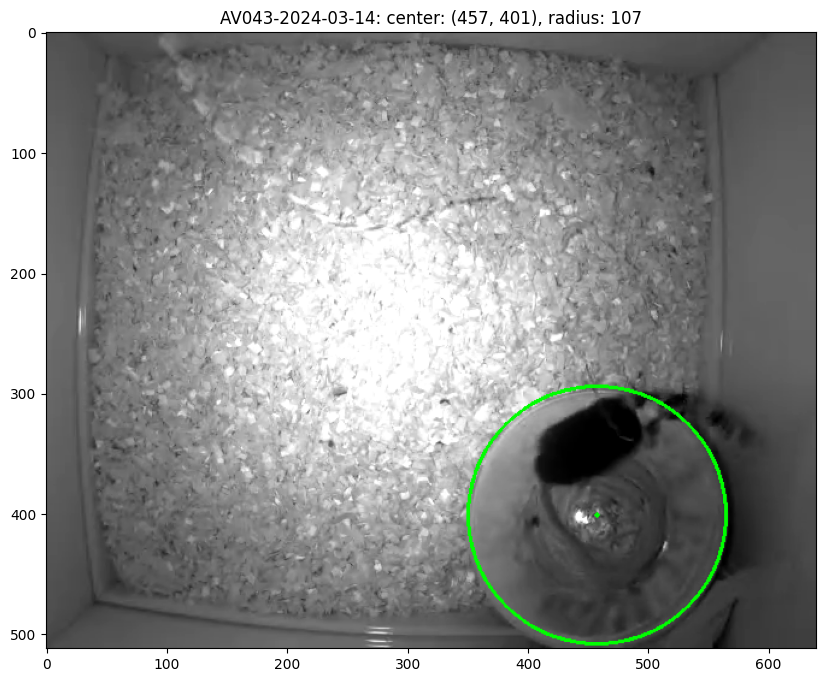

In [12]:
binned_x, binned_y, velocity, wheel_velocity, arena_mask, wheel_mask, time_bins, exp_kwargs = load_and_process_session(subject_id, date)

In [32]:
oa_running, wh_running = get_speed_masks( velocity, wheel_velocity, arena_mask, wheel_mask)

In [33]:
print(np.where(oa_running == False))

(array([    0,     1,     2, ..., 55156, 55157, 55158], dtype=int64),)


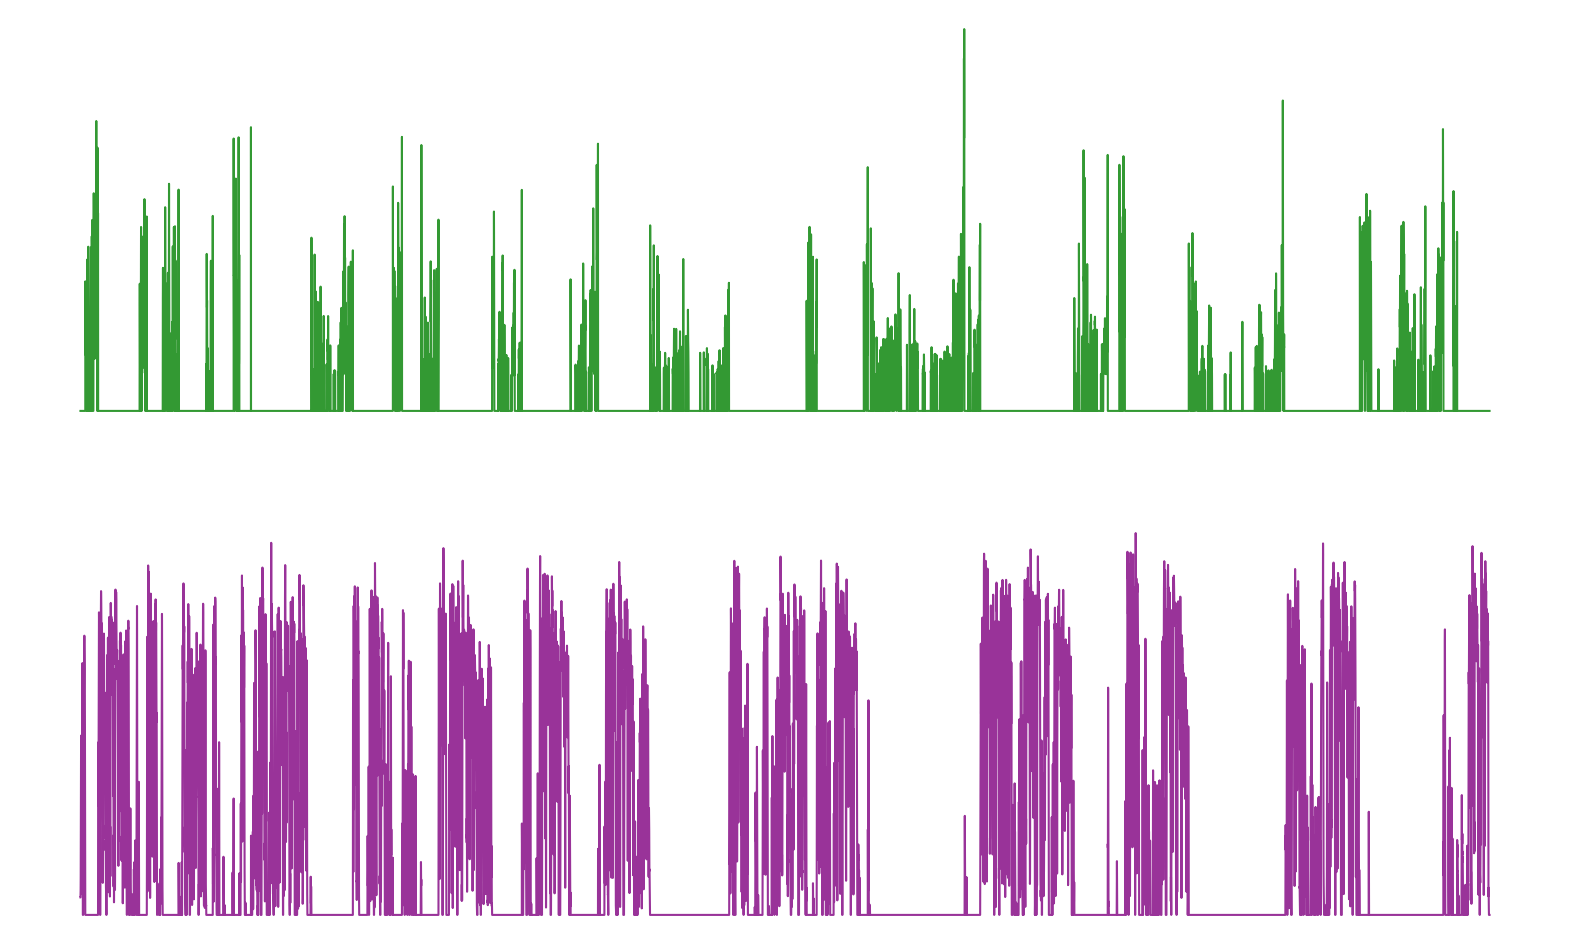

In [37]:
velocity[~oa_running] = 0 
wheel_velocity[~wh_running] = 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), 
                                       gridspec_kw={'height_ratios': [1, 1]},
                                       sharex=True)
    
    # Plot velocities
ax1.plot(velocity, color='green', alpha=0.8)
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
   #ax1.set_ylabel('Free Running Velocity (cm/s)', color='green')

ax2.plot(wheel_velocity, color='purple', alpha=0.8)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)